## Set up imports and google connection

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
GOOGLE = False
import tensorflow as tf

Check GPU availability

In [3]:
gpu = tf.config.list_logical_devices('GPU')[0].name
print(gpu)
print(tf.reduce_sum(tf.random.normal([1000, 1000])))
print(tf.test.is_gpu_available())


/device:GPU:0
tf.Tensor(451.60135, shape=(), dtype=float32)
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [4]:
import numpy as np
import os

In [5]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [6]:
if GOOGLE:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install -q kaggle
    ! mkdir ~/.kaggle
    ! cp kaggle.json ~/.kaggle/
    !chmod 600 /root/.kaggle/kaggle.json
    !kaggle datasets download -d grassknoted/asl-alphabet
    !unzip "/content/asl-alphabet.zip" -d "/content/dataset/"

In [7]:
if GOOGLE:
    # TODO: Fill in the Google Drive path where you uploaded the assignment
    # Example: If you create a CS_639 folder and put all the files under PS2 folder, then 'CS_639/PS2'
    GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'asl-alphabet'
    GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
    print(os.listdir(GOOGLE_DRIVE_PATH))
    import sys
    sys.path.append(GOOGLE_DRIVE_PATH)

## Load all data

### Unzip only if first time using dataset

In [8]:
if False:
  !unzip "/content/drive/My Drive/asl-alphabet/asl-alphabet.zip" -d "/content/drive/My Drive/asl-alphabet/"

### Use Keras to load train/validation sets

Google based path

In [9]:
if GOOGLE:
    TRAIN_DIR = os.path.join("/content/dataset/", 'asl_alphabet_train', 'asl_alphabet_train')
    TEST_DIR = os.path.join("/content/dataset/", 'asl_alphabet_test', 'asl_alphabet_test')

    img_height = 200
    img_width = 200
    batch_size = 8

Local based filesystem

In [7]:
if not GOOGLE:
    TRAIN_DIR = os.path.join('asl_alphabet_train', 'asl_alphabet_train')
    TEST_DIR = os.path.join('asl_alphabet_test', 'asl_alphabet_test')

    img_height = 200
    img_width = 200
    batch_size = 8

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_DIR,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(200, 200),
  batch_size=batch_size)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.


In [9]:
validation_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_DIR,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


In [10]:
classes = train_ds.class_names
print([c for c in classes])

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


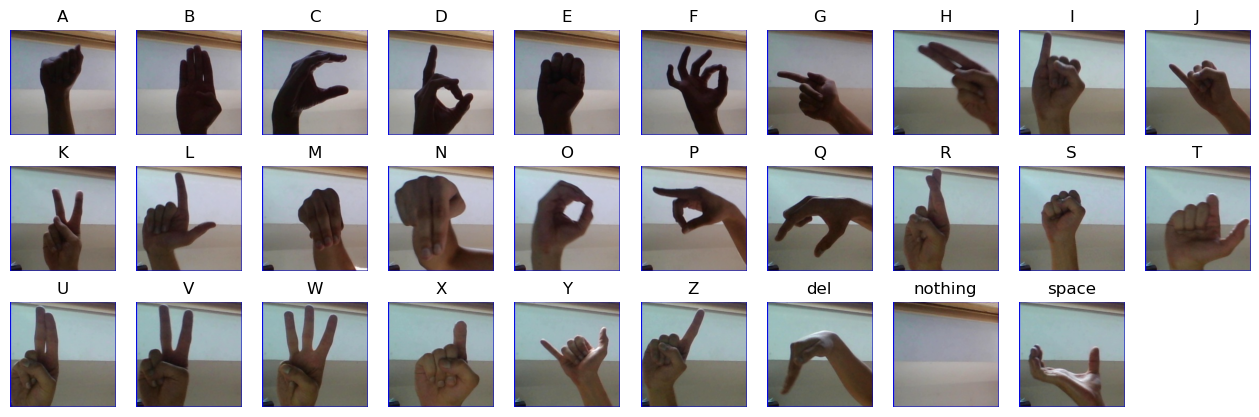

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,5))

for i in range(29):
  ax = plt.subplot(3, 10, i + 1)
  path = TRAIN_DIR + "/{0}/{0}1.jpg".format(classes[i])
  plt.imshow(plt.imread(path))
  plt.title(classes[i])
  plt.axis("off")

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valiadtion_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Set up Sequential Model

In [21]:
num_classes = len(classes)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        1

In [24]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/10
2175/2175 [==============================] - 245s 87ms/step - loss: 0.7428 - accuracy: 0.7694 - val_loss: 0.1452 - val_accuracy: 0.9542
Epoch 2/10
2175/2175 [==============================] - 178s 82ms/step - loss: 0.0994 - accuracy: 0.9677 - val_loss: 0.1382 - val_accuracy: 0.9526
Epoch 3/10
2175/2175 [==============================] - 179s 82ms/step - loss: 0.0541 - accuracy: 0.9825 - val_loss: 0.0517 - val_accuracy: 0.9829
Epoch 4/10
2175/2175 [==============================] - 176s 81ms/step - loss: 0.0436 - accuracy: 0.9861 - val_loss: 0.0924 - val_accuracy: 0.9707
Epoch 5/10
2175/2175 [==============================] - 180s 83ms/step - loss: 0.0311 - accuracy: 0.9898 - val_loss: 0.0417 - val_accuracy: 0.9879
Epoch 6/10
2175/2175 [==============================] - 182s 84ms/step - loss: 0.0287 - accuracy: 0.9911 - val_loss: 0.0534 - val_accuracy: 0.9823
Epoch 7/10
2175/2175 [==============================] - 182s 84ms/step - loss: 0.0275 - accuracy: 0.9921 - val_loss: 0

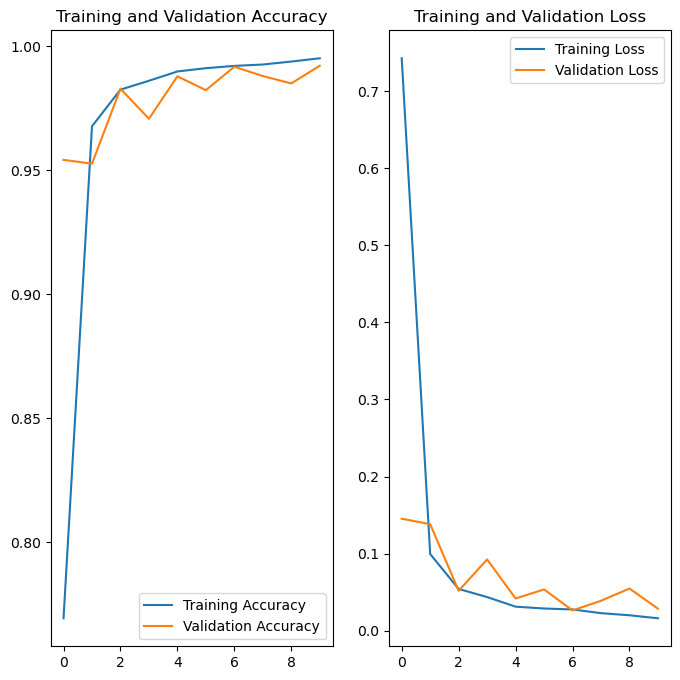

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Use Custom ResNet50

In [16]:
from resnet import ResNet50

net50 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  ResNet50(num_classes=29)])

### Define optimizer, loss function, and metrics to track

Optimizer is Adam
Loss is Categorical Cross Entropy, using sparsely defined labels (not one-hot encoded)
Metric being focused on is accuracy

In [17]:
net50.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

Display ResNet50 composition

In [18]:
net50.build((32,200,200,3))
net50.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 ResNet50 (ResNet)           (None, 29)                23647133  
                                                                 
Total params: 23,647,133
Trainable params: 23,594,013
Non-trainable params: 53,120
_________________________________________________________________


### Overfit within 10 epochs

In [19]:
epochs=10
history = net50.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/10
8700/8700 [==============================] - 1483s 169ms/step - loss: 0.7689 - accuracy: 0.7840 - val_loss: 0.5935 - val_accuracy: 0.8468
Epoch 2/10
8700/8700 [==============================] - 1605s 185ms/step - loss: 0.1215 - accuracy: 0.9615 - val_loss: 0.0231 - val_accuracy: 0.9925
Epoch 3/10
8700/8700 [==============================] - 1560s 179ms/step - loss: 0.0603 - accuracy: 0.9815 - val_loss: 0.1417 - val_accuracy: 0.9623
Epoch 4/10
8700/8700 [==============================] - 1519s 175ms/step - loss: 0.0377 - accuracy: 0.9886 - val_loss: 0.0640 - val_accuracy: 0.9815
Epoch 5/10
8700/8700 [==============================] - 1644s 189ms/step - loss: 0.0266 - accuracy: 0.9919 - val_loss: 0.1088 - val_accuracy: 0.9874
Epoch 6/10
6050/8700 [===================>..........] - ETA: 8:07 - loss: 0.0208 - accuracy: 0.9938

KeyboardInterrupt: 

Display results from overfit

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()